# EEG analysis in MNE | ERP

This part of the tutorial shows basics of ERP analysis in MNE. We will work with the "ID001-epo.fif" file we created in the previous part of the tutorial. You can see other parts of tutorial [here](https://github.com/fzakirov/MNE-tut).

(created by Felix Zakirov https://github.com/fzakirov/)

In [ ]:
# if you are going to use MNE for the first time, you should firstly install it!

# pip install mne

In [1]:
# importing basic set of packages (as well as MNE) required in almost any data analysis pipeline
import mne
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Processing epoch data

In [5]:
# reading epochs we obtained in the previous part of the tutorial
epochs=mne.read_epochs('ID001-epo.fif')

Reading C:\Users\nilsk\ID001-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
714 matching events found
No baseline correction applied
0 projection items activated


In [6]:
# shows basic info about epochs
epochs

Number of events,714
Events,1: 1782: 1733: 1804: 18399999: 0
Time range,-0.200 – 0.500 sec
Baseline,-0.200 – 0.000 sec


We can see a total of 714 epochs for 4 stimuli: 1, 2, 3, and 4 which correspond to 80dB, 70dB, 60dB, and 50dB sounds, respectively. Our epochs are cropped in (-0.2 - 0.5 sec) range. But how exactly the data is organized within epoch object and how one can access them? We will need .get_data() method to address these points.

In [34]:
# creating dataframe array
epo_arr=epochs.get_data()

get_data() method provides a 3d-array of shape (n_epochs, n_channels, n_timesamples). If you know how to deal with NumPy arrays, it will probably be easy for you to manipulate with this type of data. For example, we can take data for only one channel below (so that the array will be 2d), as we take only one instance of the 1st axis.

In [35]:
epo_arr.shape

(714, 66, 351)

In [36]:
# selecting data for one channel
ch_index=42
print(epochs.ch_names[ch_index])
epo_arr[:,ch_index,:] #2d-array

CP3


array([[ 6.13550198e-06,  6.61633594e-06,  6.65339783e-06, ...,
         8.14684418e-06,  6.84545601e-06,  5.57016322e-06],
       [-4.87504105e-06, -3.82734635e-06, -2.87483164e-06, ...,
        -1.60833948e-05, -1.71677677e-05, -1.78002769e-05],
       [-7.92512441e-06, -8.94603167e-06, -9.46221511e-06, ...,
        -1.97400444e-06, -5.64418655e-07,  6.72144248e-07],
       ...,
       [ 4.18235534e-06,  4.32368505e-06,  4.44728816e-06, ...,
        -8.01528655e-06, -8.82823085e-06, -9.79972415e-06],
       [-7.20205590e-06, -7.08515889e-06, -6.83770612e-06, ...,
         2.83741483e-06,  3.68584362e-06,  4.37990707e-06],
       [-5.85124259e-07,  6.99382234e-08,  7.70800878e-07, ...,
         1.51712108e-06,  7.50863770e-07, -2.01572096e-07]])

Alternatively, we can get the epoch data by another method .to_data_frame() which returns Pandas dataframe object containing all epochs data. In this format the data will be organized more user-friendly and more convenient to export, for example, to .xlsx or .csv file. As axpected, we will be able to apply all Pandas dataframe methods to this object.

You may still need to use arrays in some cases purposes, so get used to this representation too and don't stick to dataframes only!

In [41]:
# creating dataframe
epo_df=epochs.to_data_frame(long_format=True)

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


In [42]:
epo_df.head()

,condition,epoch,time,channel,ch_type,value
0,3,1,-0.2,Fp1,eeg,2.257891
1,3,1,-0.2,Fz,eeg,10.720065
2,3,1,-0.2,F3,eeg,6.129261
3,3,1,-0.2,F7,eeg,-1.433200
4,3,1,-0.2,FT9,eeg,-3.032725


In [45]:
# some random dataframe aggregation as an example
epo_df.groupby(['time','condition','channel'], as_index=False).agg('mean').head()

,time,condition,channel,value
0,-0.2,1,AF3,-0.444095
1,-0.2,1,AF4,-0.548181
2,-0.2,1,AF7,0.092941
3,-0.2,1,AF8,-0.265818
4,-0.2,1,AFz,-0.688048


MNE provides a wide range of functions for plotting your epoch data, which can help a lot with exploratory analysis. Let's try some of them.

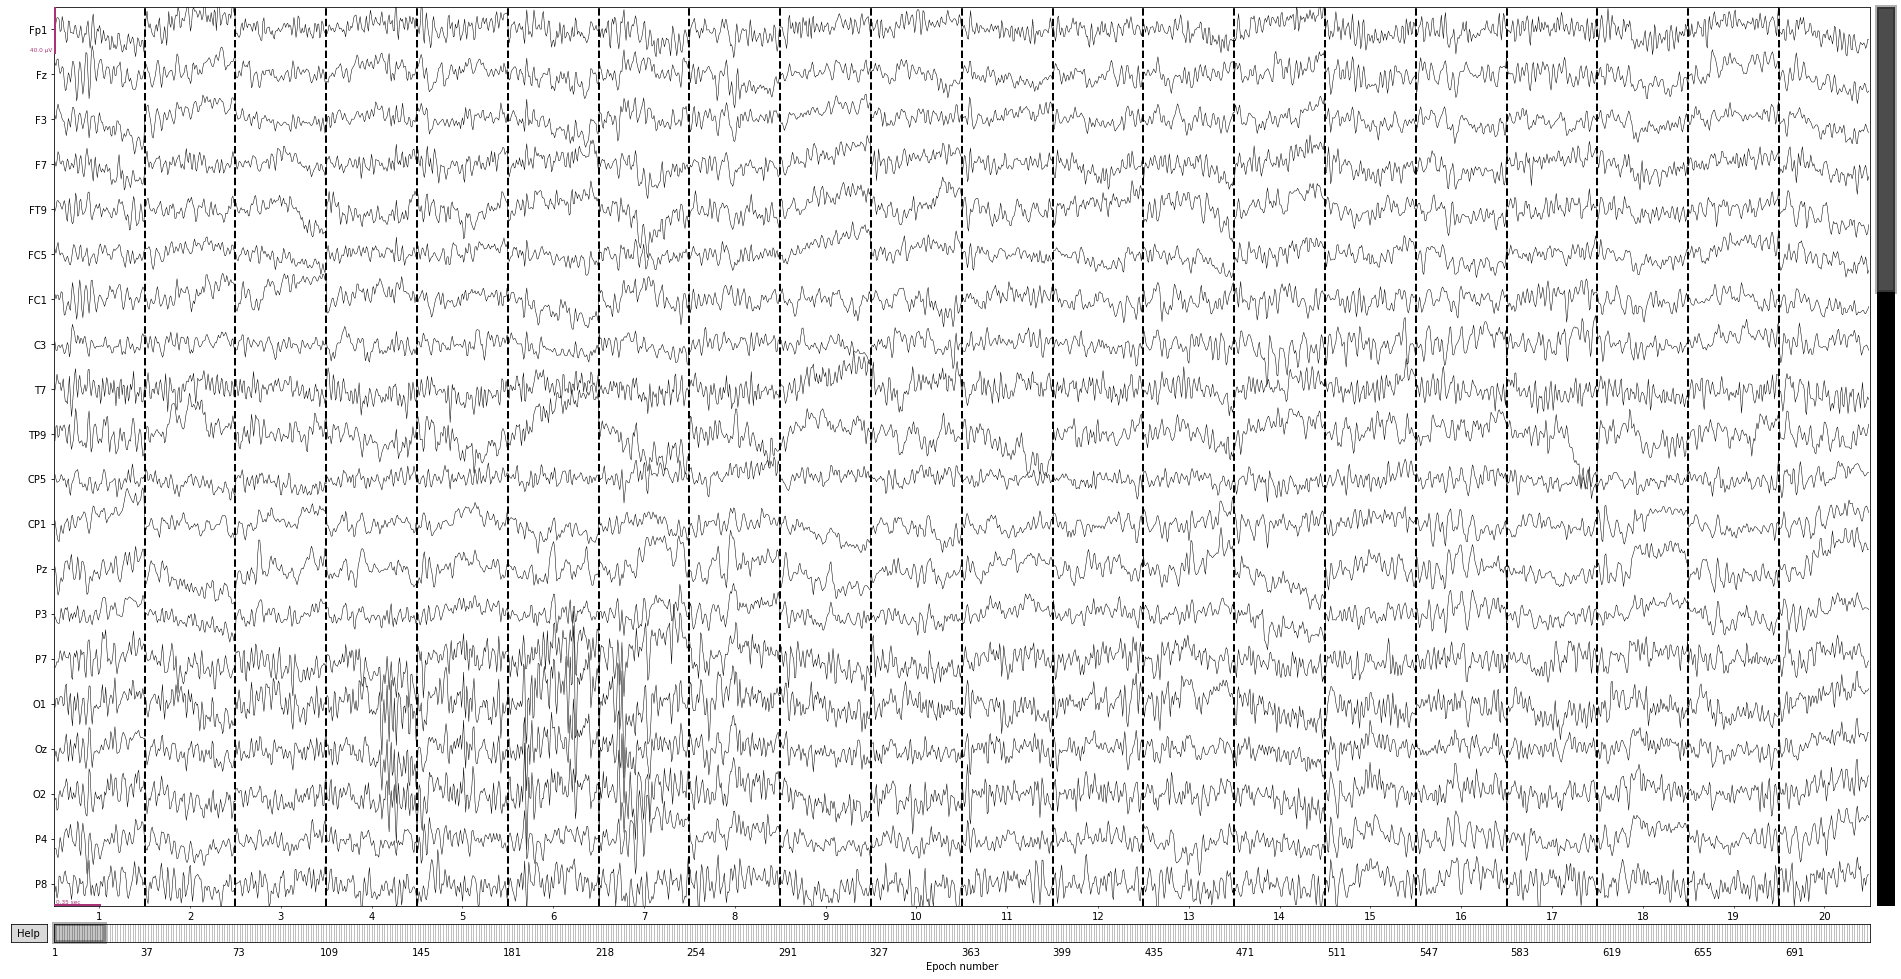

In [8]:
# basic plot method plots all epochs across all channels
epochs.plot();

Although we have already cleaned raw recording and done epoch rejection it may still be important to look at the epochs as a whole, as shown above. So that we can reassure we have epochs of good quality. 

Our subsequent analysis will be more focused, as we want to look at ERP structure and compare evoked responses to different stimuli. We can start with creating subsets of epoch object to get a set of epochs for certain stimulus.

In [13]:
# creating epochs object for each stimulus type
epo_50_db=epochs['4']
epo_60_db=epochs['3']
epo_70_db=epochs['2']
epo_80_db=epochs['1']

Each of these subsets contains about 170+ epochs for each sound intensity. At this stage, we want to average all epochs of a certain type to look at them more precisely. As you average your epoch object, it is no longer an epoch, but an evoked object. In terms of 3d-array we had from the epoch data you can think of shrinking the n_epochs axis and getting 2d-array of evoked data (n_channels, n_timesamples)

In [46]:
# averaging epoch data to get evokeds
evo_50_db=epo_50_db.average()
evo_60_db=epo_60_db.average()
evo_70_db=epo_70_db.average()
evo_80_db=epo_80_db.average()

In [49]:
# check if the data is really 2d
evo_50_db.get_data().shape

(63, 351)

You may have noticed, by the way, that n_channels has changed from 66 to 63 somehow. Why do you think this could happen?

## Plotting

MNE offers various ways to do visualze evoked data. Let's check out some of them.

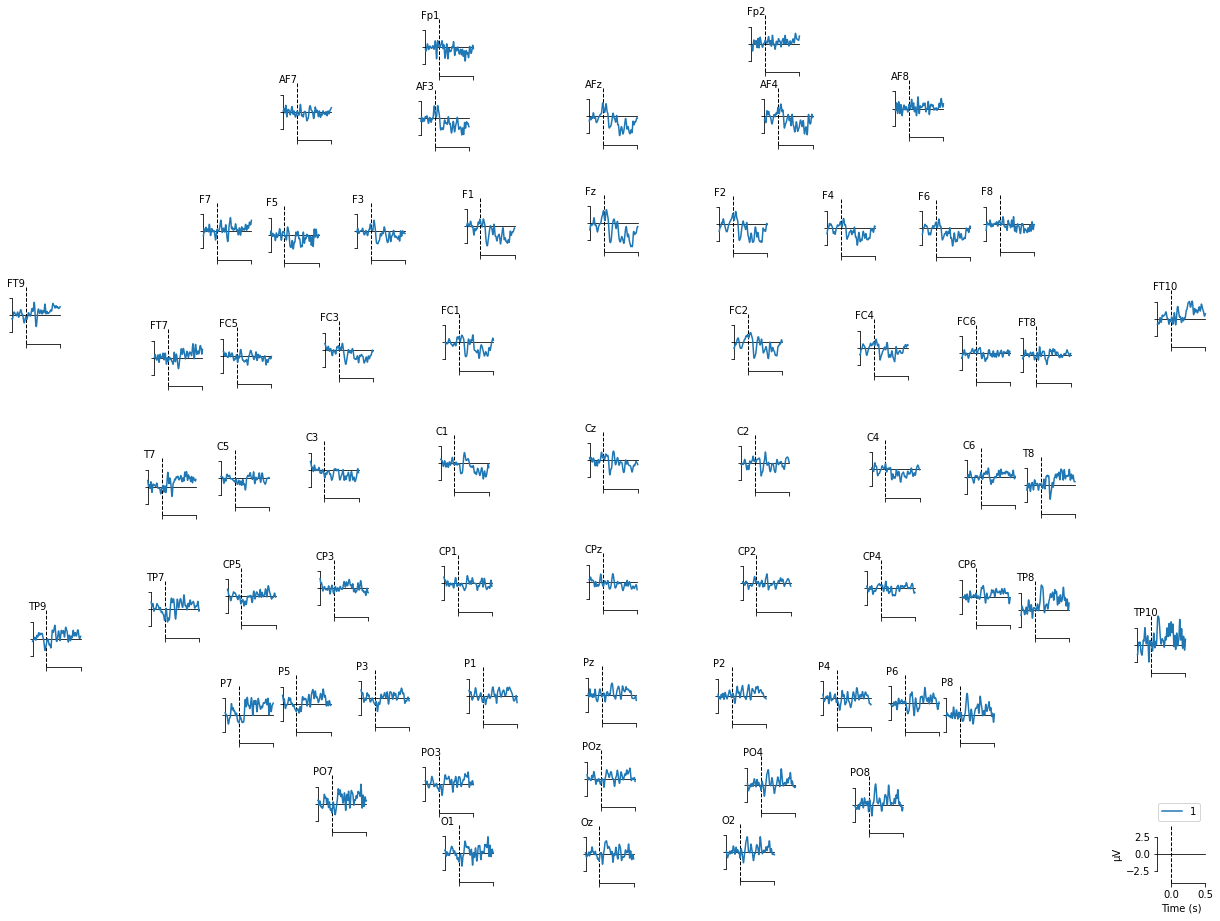

In [65]:
mne.viz.plot_compare_evokeds(evo_80_db, axes='topo');
plt.show()

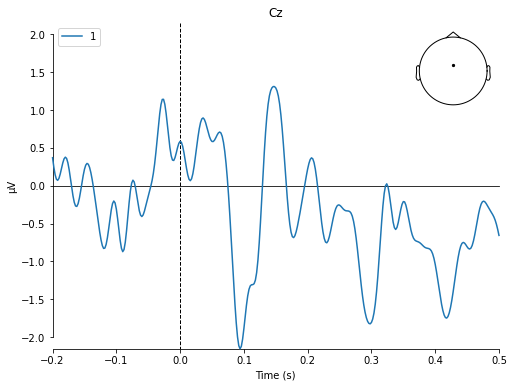

In [66]:
channel='Cz'
mne.viz.plot_compare_evokeds(evo_80_db, picks=channel);
plt.show()

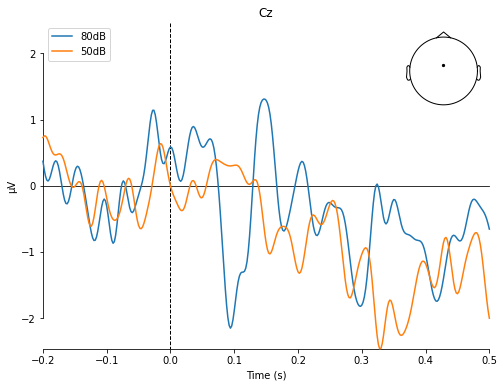

In [67]:
channel='Cz'
mne.viz.plot_compare_evokeds({'80dB':evo_80_db,
                              '50dB':evo_50_db},picks=channel);
plt.show()

You shall understand that these plotting functions make most of the work for you and you don't even need to work with arrays yourself. However, it is important to understand what is happening under the hood and be able to replicate such plots (at least those like above). Below I'll show how we can replicate the plot above using the arrays from evoked data.

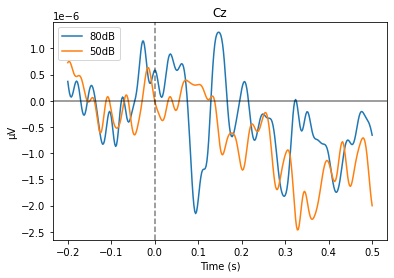

In [133]:
ch_index=evo_50_db.ch_names.index(channel)
arr_50=evo_50_db.get_data()[ch_index,:]
arr_80=evo_80_db.get_data()[ch_index,:]
times=evo_50_db.times

plt.plot(times, arr_80, color='C0')
plt.plot(times, arr_50, color='C1')
plt.legend(labels=['80dB','50dB'], loc='upper left')
plt.axhline(0, color='black', alpha=0.5)
plt.axvline(0, color='black', alpha=0.5, ls='--')
plt.xlabel('Time (s)')
plt.ylabel('µV')
plt.title('{}'.format(evo_50_db.ch_names[ch_index]))
plt.show()

OK close enough. Hope this was useful and we can proceed to another set of plotting functions.

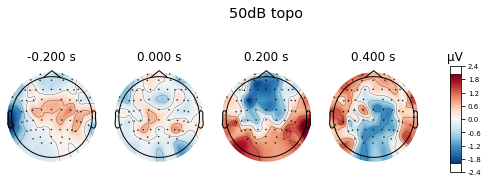

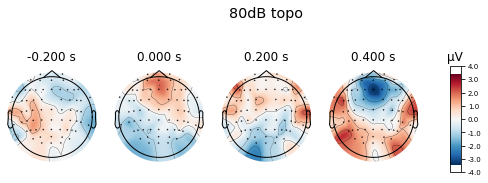

In [81]:
evo_50_db.plot_topomap(times=[-0.2, 0.0, 0.2, 0.4], title='50dB topo');
evo_80_db.plot_topomap(times=[-0.2, 0.0, 0.2, 0.4], title='80dB topo');

No projector specified for this dataset. Please consider the method self.add_proj.


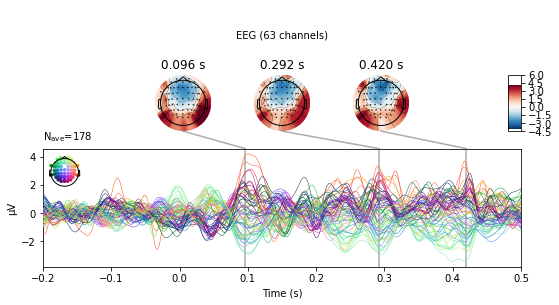

In [76]:
evo_80_db.plot_joint();